### PyTorch model

In [1]:
# import warnings
# warnings.filterwarnings("ignore")
from fastai.vision import *

In [2]:
# model
model = models.resnet18(True)

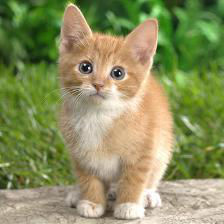

In [3]:
img = open_image('superres/cat224x224.jpg'); img

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img.shape, img.data

(torch.Size([3, 224, 224]),
 tensor([[[0.1373, 0.1176, 0.1098,  ..., 0.4196, 0.4471, 0.4588],
          [0.1255, 0.1137, 0.1098,  ..., 0.4235, 0.4431, 0.4588],
          [0.1216, 0.1098, 0.1098,  ..., 0.4078, 0.4275, 0.4392],
          ...,
          [0.7137, 0.7216, 0.6863,  ..., 0.7333, 0.7098, 0.6510],
          [0.6863, 0.6902, 0.6706,  ..., 0.8431, 0.8039, 0.7176],
          [0.6863, 0.6824, 0.6980,  ..., 0.8549, 0.8118, 0.7098]],
 
         [[0.2745, 0.2549, 0.2510,  ..., 0.6196, 0.6510, 0.6706],
          [0.2627, 0.2510, 0.2510,  ..., 0.6235, 0.6510, 0.6667],
          [0.2549, 0.2431, 0.2431,  ..., 0.6157, 0.6353, 0.6471],
          ...,
          [0.6627, 0.6706, 0.6353,  ..., 0.6824, 0.6588, 0.6000],
          [0.6353, 0.6392, 0.6196,  ..., 0.7922, 0.7529, 0.6667],
          [0.6353, 0.6314, 0.6471,  ..., 0.8039, 0.7608, 0.6588]],
 
         [[0.1490, 0.1255, 0.1098,  ..., 0.3569, 0.3686, 0.3765],
          [0.1333, 0.1216, 0.1098,  ..., 0.3608, 0.3686, 0.3843],
          [0

### Pytorch to ONNX model

In [6]:
content_image = normalize(img.data, 
          torch.tensor(imagenet_stats[0]), 
          torch.tensor(imagenet_stats[1]))

In [7]:
# convert to onnx
torch_output = torch.onnx._export(model, content_image[None, :], './resnet18.onnx').cpu()

In [8]:
torch_output = to_np(torch_output)

In [9]:
torch_output

array([[-0.048182,  1.029677, -0.967054, -1.356787, ...,  1.44648 , -1.591725,  2.631573,  3.197955]], dtype=float32)

### ONNX to TF model

In [14]:
# onnx to tf
import onnx
from onnx_tf.backend import prepare
import onnx_tf
import tensorflow as tf

/home/ubuntu/anaconda3/lib/python3.6/site-packages/onnx_tf-1.2.1-py3.6.egg/onnx_tf/common/__init__.py:87: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/onnx_tf-1.2.1-py3.6.egg/onnx_tf/common/__init__.py:87: UserWarning: FrontendHandler.get_outputs_names is deprecated. It will be removed in future release. Use node.outputs instead.
  warnings.warn(message)


In [25]:
# convert to onnx
# Reference https://github.com/onnx/onnx-tensorflow/issues/167
#tf_rep = prepare(onnx_model) # whthout strict=False leads to KeyError: 'pyfunc_0'
onnx_model = onnx.load("./resnet18.onnx")  # load onnx model
tf_rep = prepare(onnx_model, strict=False)  # prepare tf representation
tf_rep.export_graph("./resnet18.pb")  # export the model

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
input_image = to_np(content_image)[None, ...]; input_image.shape

(1, 3, 224, 224)

In [ ]:
# check tf_rep output
output_onnx_tf = tf_rep.run(input_image)

In [16]:
np.all(np.isclose(input_image, input_image+1e-10))

True

In [ ]:
import numpy as np

In [ ]:
# step 3, check if tf.pb is right.
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
config=tf.ConfigProto(gpu_options=gpu_options)

with tf.Graph().as_default():
    graph_def = tf.GraphDef()
    with open("./resnet18.pb", "rb") as f:
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name="")

    with tf.Session(config=config) as sess:
        #init = tf.initialize_all_variables()
        init = tf.global_variables_initializer()
        #sess.run(init)

        # print all ops, check input/output tensor name.
        # uncomment it if you donnot know io tensor names.
        '''
        print('-------------ops---------------------')
        op = sess.graph.get_operations()
        for m in op:
            print(m.values())
        print('-------------ops done.---------------------')
        '''

        input_x = sess.graph.get_tensor_by_name("0:0") # input
        output = sess.graph.get_tensor_by_name('add_9:0') # 5
        output_tf_pb = sess.run([output], feed_dict={input_x:input_image})
        print('output_tf_pb = {}'.format(output_tf_pb))

### ONNX to coreml model

In [14]:
# !pip install netron

In [16]:
# visually inspect model to find input and output names
import netron
netron.start('resnet18.onnx', port=9999)

Serving 'resnet18.onnx' at http://:9999


In [19]:
# !pip install -U onnx-coreml

In [20]:
from onnx import onnx_pb
from onnx_coreml import convert

model_file = open('resnet18.onnx', 'rb')
model_proto = onnx_pb.ModelProto()
model_proto.ParseFromString(model_file.read())
coreml_model = convert(model_proto, image_input_names=['0'], image_output_names=['198'])
coreml_model.save('./resnet18.mlmodel')

ValueError: not enough values to unpack (expected 3, got 0)